# Convolutional Autoencoder

Sur dataset OBAMA voir drive


In [16]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial

In [17]:
"préparation des données"
path = 'lips//res//frame'
nframe=10000

trainingLength = int(0.9*nframe)   #Nombre de frame que l'on garde pour l'entrainement, le reste sera pour le test
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

image1 = rgb2gray(mpimg.imread(path  + str(1) + '.jpg')) #Load the first image

imageSize = image1.shape
num_inputs=imageSize[0]*imageSize[1]  # taille image entrée si les images ont bien été resized

lips = np.zeros((nframe,imageSize[0], imageSize[1]))

for i in range(1,nframe-1):
#    print(len(mpimg.imread(path  + str(i+1) + '.jpg')))
#    print(len(mpimg.imread(path  + str(i+1) + '.jpg')[0]))
#    lips[i-1] = np.reshape(mpimg.imread(path  + str(i+1) + '.jpg',grayscale),(41*69,1))
#    Without resizing :
    lips[i-1] = rgb2gray(mpimg.imread(path  + str(i) + '.jpg'))

lipsTrain=lips[:trainingLength]
lipsTest=lips[trainingLength:]

CNN Autoencodeur


In [24]:
learning_rate = 0.001
n_hidden3=10
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None, 48,80,1), name="input")
targets_ = tf.placeholder(tf.float32, (None, 48,80,1), name="target")
initializer = tf.contrib.layers.variance_scaling_initializer()


### Encoder
conv1 = tf.layers.conv2d(inputs=inputs_, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 48x80x32
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=(2,2), strides=(2,2), padding='same')
# Now 24x40x32
conv2 = tf.layers.conv2d(inputs=maxpool1, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 24x40x16
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding='same')
# Now 12x20x16

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)
hidden3_mean = my_dense_layer(maxpool2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(maxpool2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise

# Now d
#layer2=tf.layers.dense(inputs=hidden3, activation=tf.nn.relu, units=12*20*16)


### Decoder

# Now 12x20x16
conv5 = tf.layers.conv2d(inputs=hidden3, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 24x40x16
upsample3 = tf.image.resize_images(conv5, size=(48,80), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# Now 48x80x16
conv6 = tf.layers.conv2d(inputs=upsample3, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 48x80x32

logits = tf.layers.conv2d(inputs=conv6, filters=1, kernel_size=(3,3), padding='same', activation=None)
#Now 48x80x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the square loss
latent_loss = 0.5 * tf.reduce_sum()

loss = latent_loss+tf.square(targets_-logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [25]:
sess = tf.Session()

In [26]:
epochs = 1
batch_size = 50
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(len(lipsTrain)//batch_size):
        batch = lipsTrain[ii*batch_size:(ii+1)*batch_size]
        imgs = batch.reshape((-1, 48, 80, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost)) 

Epoch: 1/1... Training loss: 493314979323560591360.0000
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan
Epoch: 1/1... Training loss: nan


KeyboardInterrupt: 

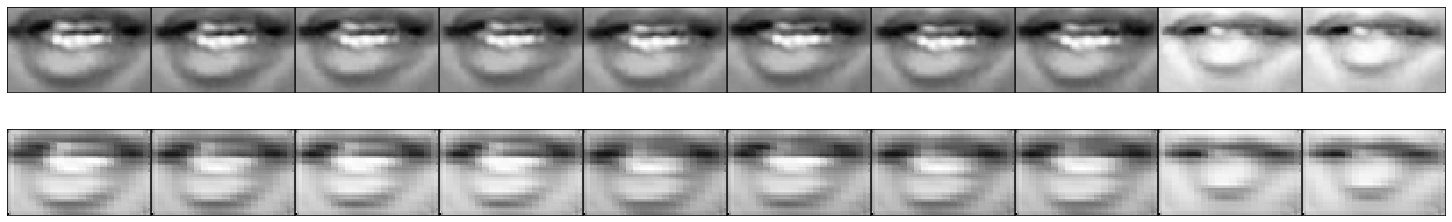

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = lipsTest[:10]
reconstructed = sess.run(logits, feed_dict={inputs_: in_imgs.reshape((10, 48, 80, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((48, 80)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [9]:
sess.close()